# Figure 3i. Shared cell-types in primary CoS and secondary CoS.

For each gene with multiple CoS, we consider a pair of primary CoS and secondary CoS, and evaluate the number of brain cell type pseudo-bulk eQTLs showing shared effects for each CoS in the pair. We present a heatmap of the number of pairs of primary and secondary CoS, showing different patterns of sharing across brain cell type eQTLs.

In [10]:
library(tidyverse)
res <- readRDS("data/xQTL_only_colocalization.rds")

## Organize input data

In [12]:
filtered_coloc_info <- res %>%
  group_by(gene) %>%
  filter(n() > 1) %>%
  ungroup()  # Optionally, ungroup to remove the grouping structure
filtered_coloc_info <- within(filtered_coloc_info, {
  change_loglik <- as.numeric(unlist(profile_change))
  num_phen <- as.factor(unlist(num_phen))
  coloc_sets <- unlist(coloc_sets)
  gene <- unlist(gene)
})
phenotypes_to_count <- c("Mic", "Exc", "Ast", "Oli", "OPC", "Inh")
filtered_coloc_info <- filtered_coloc_info %>%
  mutate(count_phenotypes = str_count(colocalized_phenotypes, paste(phenotypes_to_count, collapse = "|")))

In [14]:
# 1. Primary coloc_csets with the highest change_loglik for each gene
primary_sets <- filtered_coloc_info %>%
  group_by(gene) %>%
  filter(change_loglik == max(change_loglik)) %>%
  ungroup()

# 2.  Secondary coloc_csets
secondary_sets <- filtered_coloc_info %>%
  anti_join(primary_sets,
            by = c("coloc_sets", "gene", "num_phen", "colocalized_phenotypes", "change_loglik"))
# 3. Create tmp_primary with the same dimensions as secondary_sets
secondary_sets <- as_tibble(secondary_sets)
primary_sets <- as_tibble(primary_sets)
test_select <- dplyr::select(secondary_sets, gene)
tmp_primary <- secondary_sets %>%
  left_join(primary_sets, by = "gene")
result <- tibble(
  gene = secondary_sets$gene,
  primary_count = tmp_primary$count_phenotypes.y,
  secondary_count = secondary_sets$count_phenotypes,
  primary_idx = tmp_primary$colocalized_index.y,
  secondary_idx = secondary_sets$colocalized_index
)

In [15]:
summary_df <- result %>%
  group_by(primary_count, secondary_count) %>%
  summarize(count = n()) %>%
  ungroup()

full_grid <- expand.grid(primary_count = 1:6, secondary_count = 1:6)
heatmap_data <- full_grid %>%
  left_join(summary_df, by = c("primary_count", "secondary_count")) %>%
  replace_na(list(count = 0))

`summarise()` has grouped output by 'primary_count'. You can override using the
`.groups` argument.


## Plot

In [16]:
library(ggplot2)
library(RColorBrewer)
# Create the heatmap with ggplot2
values <- c(seq(0, 0.15, 0.005), 0.2, 0.3, 0.5, 0.75, 1)
colors <- colorRampPalette(c("white", brewer.pal(n = 9, name = 'YlOrRd')))(45)[1:length(values)]
p1 <- ggplot(heatmap_data, aes(x = primary_count, y = secondary_count, fill = count)) +
  geom_tile(color = "black", linewidth = 1) +  # Add black boundary for each cell
  geom_text(aes(label = count), color = "black", size = 5.5) +
  scale_fill_gradientn(
    colors = colors,
    values = values,
    breaks = c(0, 20, 40, 60, 80, 100, 300, 500),
    limits = c(0, max(heatmap_data$count))
  ) +
  scale_x_continuous(breaks = 1:6) +
  scale_y_continuous(breaks = 1:6) +
  labs(x = "Number of shared cell types\n in primary CoS",
       y = "Number of shared cell types\n in secondary CoS",
       title = "",
       fill = "Count") +
  theme_minimal() +
  theme(
    legend.position = "none",
    panel.grid = element_blank(),
    axis.title.x = element_text(size = 24),
    axis.title.y = element_text(size = 24),
    axis.text.x = element_text(size = 18, margin = margin(t = -10)),
    axis.text.y = element_text(size = 18, margin = margin(r = -10)),
    plot.title = element_text(size = 0, face = "bold", vjust = -1, hjust = 0.5)
  )


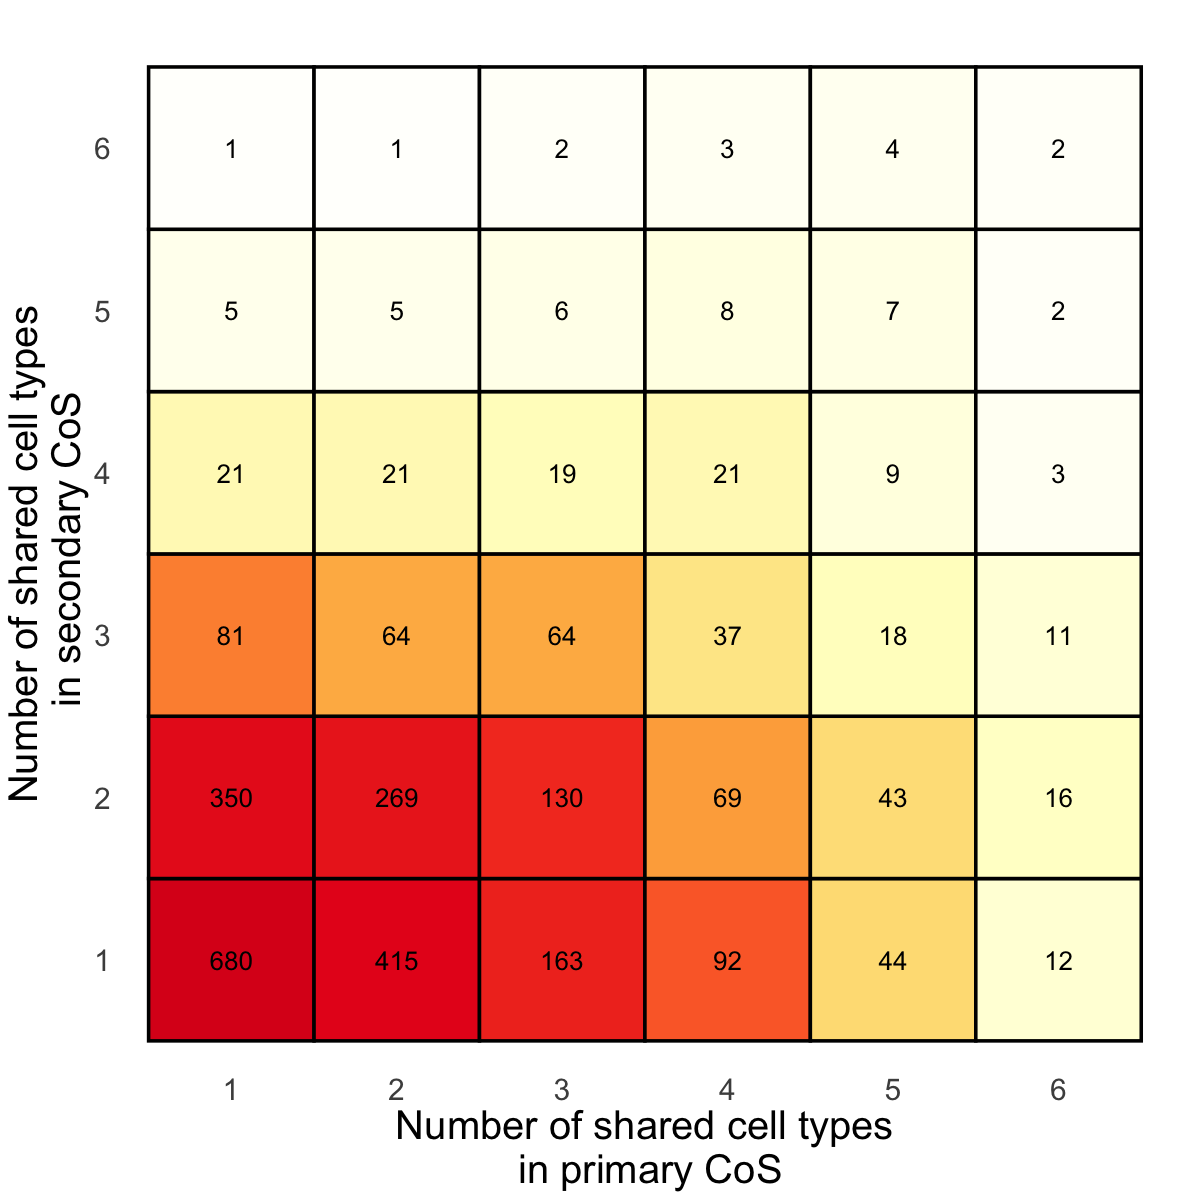

In [17]:
options(repr.plot.width = 10, repr.plot.height = 10)
p1